# Time Series Forecast - Police Stops

## Libraries

In [71]:
import sagemaker
import boto3
from datetime import datetime
from io import StringIO
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [48]:
%store -r diff_ripa
%store -r ripa_stops_df_cleaned
%store -r ripa_stops_ts 

%store -r ripa_stops_log 
%store -r decom_ripa 
%store -r trend_ripa_stops 
%store -r season_ripa_stops 
%store -r resid_ripa_stops 
%store -r ripa_stops_m



# Autocorrelation Function and Partial Autocorrelation Function

In [49]:
acf_ripa_stops = acf(diff_ripa, nlags=20, fft=False)
pacf_ripa_stops = pacf(diff_ripa, nlags=20, method='ols')

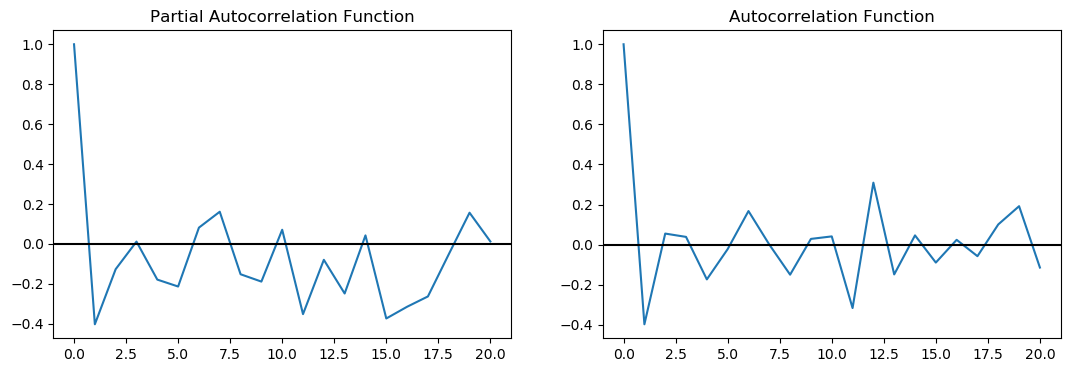

In [50]:
# Plotting PACF

f = plt.figure()
f.set_figwidth(13)
f.set_figheight(4)




plt.subplot(121)
plt.plot(pacf_ripa_stops)
plt.axhline(y=0, color="black")
plt.title("Partial Autocorrelation Function")

# Plotting ACF

plt.subplot(122)
plt.plot(acf_ripa_stops)
plt.axhline(y=0, color="black")
plt.title("Autocorrelation Function")

plt.show()

# Split Dataset for Training, Testing, and Validation

In [51]:
# training 80%, testing 20%

total = len(ripa_stops_ts)
#print("Total Amount: ", total)

# training set
ripa_stops_train = ripa_stops_ts[  :int(len(ripa_stops_ts)*0.8)]

# testing set
ripa_stops_test = ripa_stops_ts[  int(len(ripa_stops_ts)*0.8) : ]



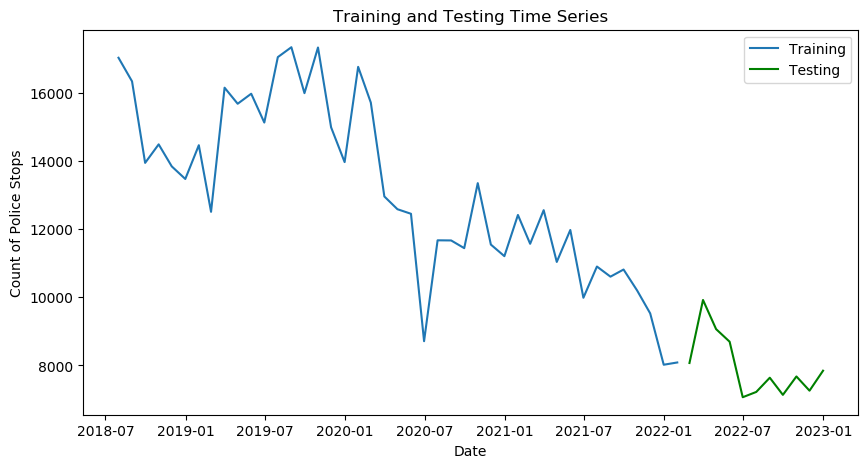

In [52]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)


plt.plot(ripa_stops_train)
plt.plot(ripa_stops_test, color='green')

plt.title("Training and Testing Time Series")
plt.xlabel("Date")
plt.ylabel("Count of Police Stops")
plt.legend(['Training', 'Testing'])
plt.show()

## ARIMA Model

## Plot Actuals Against Fitted Values

<Figure size 1500x1000 with 0 Axes>

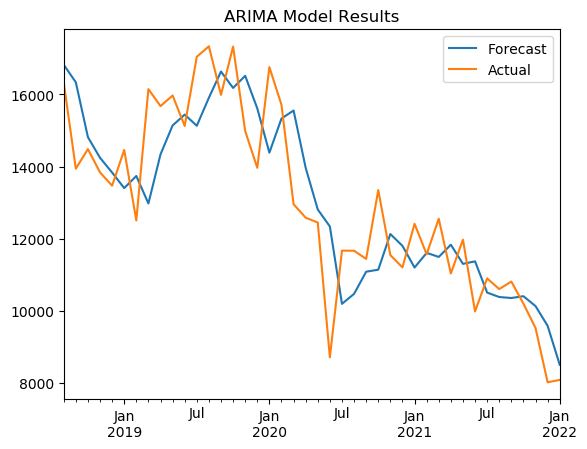

In [53]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)

arima_model = ARIMA(ripa_stops_train, order = (1,1,1))
arima_output = arima_model.fit(disp=0)

arima_output.plot_predict()

plt.title("ARIMA Model Results")
plt.legend(["Forecast", "Actual"])
plt.show()


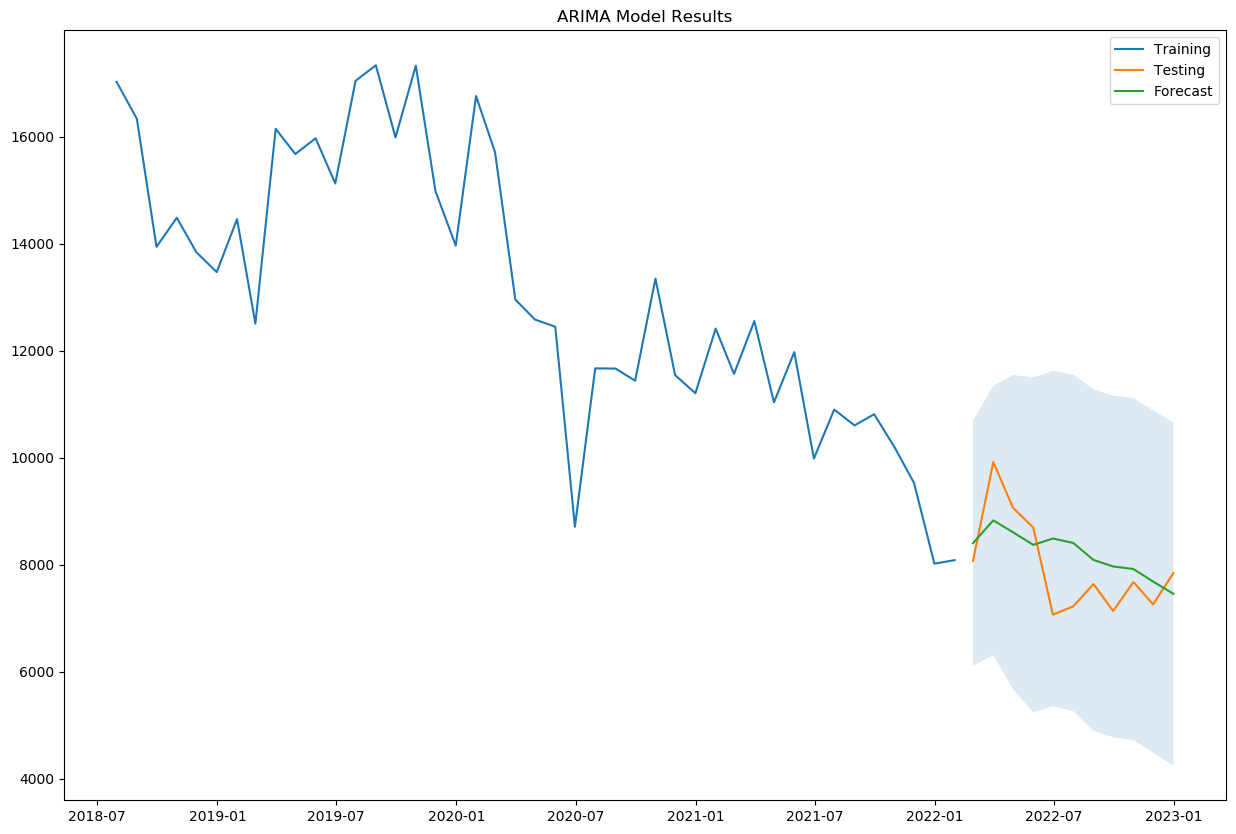

In [104]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)

arima_model = ARIMA(ripa_stops_train, order = (3,1,3))
arima_output = arima_model.fit(disp=0)


forecast, series, confidence = arima_output.forecast(11, alpha = 0.05)

forecast_s = pd.Series(forecast, index = ripa_stops_test.index)
low_bound = pd.Series(confidence[: , 0], index = ripa_stops_test.index)
high_bound = pd.Series(confidence[: , 1], index = ripa_stops_test.index)


plt.plot( ripa_stops_train)
plt.plot( ripa_stops_test)
plt.plot( forecast_s)
plt.fill_between(low_bound.index, low_bound, high_bound, alpha = .15)


#plt.legend(["Training", "Testing", "Forecast"])
plt.title("ARIMA Model Results")
plt.legend(["Training", "Testing", "Forecast"])
plt.show()

In [105]:
print(arima_output.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.count   No. Observations:                   42
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -359.346
Method:                       css-mle   S.D. of innovations           1169.765
Date:                Sun, 16 Apr 2023   AIC                            734.691
Time:                        07:08:37   BIC                            748.593
Sample:                    08-31-2018   HQIC                           739.787
                         - 01-31-2022                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -178.1432     39.622     -4.496      0.000    -255.801    -100.485
ar.L1.D.count     0.3017      0.169      1.785      0.074      -0.030       0.633
ar.L2.D.count    -0.4746      0.134     

# Accuracy Metrics of ARIMA Model

In [116]:
# MAPE Value

mape = round(np.mean(np.abs( (forecast - ripa_stops_test.values) / ripa_stops_test.values) ) , 4)


print("MAPE Value: ", mape)


MAPE Value:  0.0836


In [119]:
# MPE Value

mpe = round( np.mean( (forecast - np.abs(ripa_stops_test.values) / np.abs(ripa_stops_test.values) )) , 4)

print("MPE Value: ", mpe)
               

MPE Value:  8201.5713


In [125]:
# ME Value

me = round(np.mean(np.abs(forecast - ripa_stops_test.values) ), 4)

print("ME Value: ", me)


ME Value:  650.28


In [156]:
# MSE and RMSE Values

mse_test = round( mean_squared_error(ripa_stops_test.values, forecast), 4)

print("MSE Value (Testing): ", mse_test)

RMSE_test = round( sqrt(mse_test), 4)

print("RMSE Value (Testing): ", RMSE_test)


MSE Value (Testing):  575406.5209
RMSE Value (Testing):  758.5555
